# CS211: Data Privacy
## In-Class Exercise, Week of 9/26/2022

In [2]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

## Question 1

For various values of $b$, write code to print out the percent error of summing the ages in the `adult` dataset, 
clipped to each value of $b$.

In [3]:
bs = range(1, 100, 10)
real_sum = adult['Age'].sum()

for b in [10, 20, 30, 40, 50, 90, 100, 1000, 10000, 500000]:
    clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
    noisy_sum = laplace_mech(clipped_sum, b, 0.1)
    print('b:', b, 'sum:', pct_error(real_sum, noisy_sum))

b: 10 sum: 74.07102609913392
b: 20 sum: 48.372657207949544
b: 30 sum: 27.25225840835548
b: 40 sum: 12.881834476057827
b: 50 sum: 4.82831379193132
b: 90 sum: 0.0358511629249352
b: 100 sum: 0.04476250262934804
b: 1000 sum: 0.3714307445413356
b: 10000 sum: 1.767919921207894
b: 500000 sum: 1845.6012578266889


if we want to minimize error, b should be 90. Too small and there is eror due to clipping, too big and there is error due to excessive noise.

## Question 2

For various values of $b$, print the result of a *differentially private* sum of ages, clipped to each value of $b$. Use $\epsilon = 0.1$.

In [4]:
bs = range(1, 100, 10)
real_sum = adult['Age'].sum()

for b in [10,20, 30, 40, 50, 80, 90, 100, 1000, 10000, 50000, 100000]:
    clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
    noisy_sum = laplace_mech(clipped_sum, b, 0.1)
    print('b:', b, 'sum:', pct_error(real_sum, noisy_sum))

b: 10 sum: 74.09389970140823
b: 20 sum: 48.394308890527235
b: 30 sum: 27.229477025282673
b: 40 sum: 12.810044629457797
b: 50 sum: 4.851046913307937
b: 80 sum: 0.08861137386697411
b: 90 sum: 0.06404354284294983
b: 100 sum: 0.022726587006157685
b: 1000 sum: 0.6595600890696853
b: 10000 sum: 2.2134859422051596
b: 50000 sum: 34.105181172654326
b: 100000 sum: 60.78398447590274


Which value of $b$ is the best now? Does it differ?

The best value for b is 70 <= b <= 100. If b is smaller, there are clipping errors. If b is much larger, we introduce error due to excessive noises.

## Question 3

Write an algorithm to *automatically pick the clipping parameter* for the age column. Your algorithm should satisfy differential privacy.

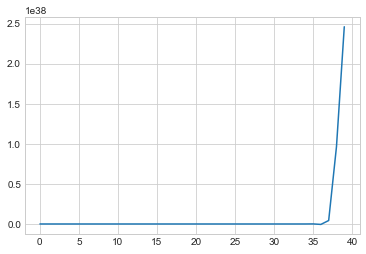

In [14]:
def pick_b(epsilon):
    # Approach: Try b values and see what works best
    bs = list(range(1, 1000, 50))
    noisy_results = {}
    for b in bs:
        clipped_sum = adult['Age'].clip(lower=0, upper=b).sum()
        # consume privacy budget every time we run laplace_mech
        noisy_sum = laplace_mech(clipped_sum, b, epsilon)
        noisy_results[b] = noisy_sum

    # goal: find the flat part of the graph
    # approach: comapre neighbor and noisy sums
    # find a pair othat are close together (noisy is no longer increasing) 
    # return the associated b value

    last_sum = -10000
    for b, noisy_sum in noisy_results.items():
        if abs(noisy_sum - last_sum) < 500:
            return b
        last_sum = noisy_sum
    return -1

[pick_b(1.0) for _ in range(5)]

epsilon = 1
plt.plot([laplace_mech(adult['Capital Gain'].clip(lower = 0, upper = b).sum(), b, epsilon) for b in [10**i for i in range(40)]])

In [9]:
# TEST CASE for question 3

many_trials = np.mean([pick_b(1.0) for _ in range(100)])
assert many_trials > 70
assert many_trials < 500

## Question 4

What is the privacy cost of your algorithm, and why?

Total privacy cost is 20 * epsilon.
- we run laplace mechanism once per value in bs
- there are 20 values in bs
- by sequential composition, the total privacy cost 20 * epsilon
- we can pick from the noisy sums without additional privacy by the post processing property

## Question 5

Write code to generate a *histogram* of education numbers in the `adult` dataset.

In [15]:
def education_hist():
    return adult['Education'].value_counts()

education_hist()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: Education, dtype: int64

In [16]:
# TEST CASE for question 5
h = education_hist()
assert h['HS-grad'] == 10501
assert h['12th'] == 433
assert h['Doctorate'] == 413

## Question 6

Write code to release a *differentially private histogram* of education numbers.

In [17]:
def dp_education_hist(epsilon):
    h = education_hist()
    dp_result = h.apply(lambda x : laplace_mech(x , 1, epsilon ))
    return dp_result

dp_education_hist(1.0)

HS-grad         10500.639118
Some-college     7290.940596
Bachelors        5353.811859
Masters          1724.279213
Assoc-voc        1380.425958
11th             1174.010021
Assoc-acdm       1064.625545
10th              930.350988
7th-8th           646.057786
Prof-school       574.952549
9th               513.823961
12th              432.520333
Doctorate         414.224223
5th-6th           333.973186
1st-4th           171.656189
Preschool          52.925941
Name: Education, dtype: float64

In [18]:
# TEST CASE for question 6
h = dp_education_hist(1.0)
assert abs(h['HS-grad'] - 10501) < 100
assert abs(h['Doctorate'] - 413) < 100

## Question 7

What is the total privacy cost of `dp_education_hist`, and why?

naive solution
- I run the laplace mechanism len(h) times, and use a privacy parameter of epsion each time 
- by sequential composition the total cost is len(h) * epsilon.
- I split the data set into chunks based on the 'education' column, and use the laplace mechanism once on each chunk

Better Solution
- the chunks are disjoint because each person  has exactly one value for the 'education' column.
- by parallel composition the total privacy cost is epsilon.

## Question 8

Write code to generate a differentially private *contingency table* for the Education and Sex columns of the `adult` dataset.

In [19]:
def dp_crosstab_education_sex(epsilon):
    # it would be nice if the total privacy cost is epsilon
    ct  = pd.crosstab(adult['Education'], 
                      adult['Sex'])
    noisy_ct = ct.applymap(lambda x : laplace_mech(x , 1, epsilon ))
    return noisy_ct

dp_crosstab_education_sex(1.0)

Sex,Female,Male
Education,,
10th,296.482294,637.069209
11th,432.449596,746.293217
12th,144.043608,287.356217
1st-4th,45.757227,122.781299
5th-6th,83.527478,248.004555
7th-8th,158.715913,486.077081
9th,146.780805,370.132696
Assoc-acdm,419.429187,645.086113
Assoc-voc,500.628115,881.261332


In [20]:
# TEST CASE for question 8
ct = dp_crosstab_education_sex(1.0)
assert abs(ct['Female']['10th'] - 295) < 100
assert abs(ct['Male']['10th'] - 638) < 100
assert abs(ct['Female']['Bachelors'] - 1619) < 100

assert abs(ct['Female']['10th'] - 295) > 0
assert abs(ct['Male']['10th'] - 638) > 0
assert abs(ct['Female']['Bachelors'] - 1619) > 0

## Question 9

Does parallel composition apply for the contingency table in question 1? Why or why not?

yes it does, parrallel composition holds for an n-dimensional histogram (including n= 2), because adding or removing an indiciviual in the data changes exactly one count in the histogram

## Question 10

Does the number of columns used in constructing the contingency table matter for privacy cost? Does it matter for accuracy?

- Privacy cost: no the number of columns does not  matter
- Accuracy: yes, it mattrs a lot. The more columns you group bu, the smaller the count will be in each of the reslt. The noise level will start the same, but the signal-to-noise ratio will go down.

## Question 11

Implement the Gaussian mechanism for $(\epsilon, \delta)$-differential privacy.

In [26]:
# Using Gauss instead of laplace to generate noise, involves a different notion of sensitivity... More sensitivity = less noise?
# Differential privacy using Gaussian noise = approximate differential privacy
#     -  Better sensitivity, doesn't satisfy epsilon DP (epsilon, delta)

def gaussian_mech(val, sensitivity, epsilon, delta):
    # Scale of the noise = 2s2log(1.25/delta)/epsilon^2
    sigma_sqt = (2*(sensitivity**2)*np.log(1.25/delta)) / (epsilon**2)
    sigma = np.sqrt(sigma_sqt)
    noise = np.random.normal(loc=0, scale = sigma)
    return val + noise

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        4.0000e+00, 6.0000e+00, 1.1000e+01, 6.0000e+00, 8.0000e+00,
        1.0000e+01, 1.3000e+01, 2.2000e+01, 3.1000e+01, 3.2000e+01,
        4.3000e+01, 4.8000e+01, 6.7000e+01, 9.7000e+01, 1.2200e+02,
        1.5400e+02, 1.6100e+02, 2.2300e+02, 2.9000e+02, 3.5500e+02,
        3.8500e+02, 5.6400e+02, 6.8800e+02, 8.9000e+02, 1.0510e+03,
        1.2750e+03, 1.6550e+03, 2.2400e+03, 2.6570e+03, 3.2310e+03,
        4.0940e+03, 5.2240e+03, 6.6420e+03, 8.1520e+03, 1.0232e+04,
        9.8130e+03, 7.8620e+03, 6.3390e+03, 5.0660e+03, 4.0540e+03,
        3.2700e+03, 2.6250e+03, 2.0370e+03, 1.6670e+03, 1.3380e+03,
        1.0640e+03, 8.3400e+02, 6.8100e+02, 5.4200e+02, 4.2900e+02,
        3.4900e+02, 2.5500e+02, 2.2500e+02, 1.7300e+02, 1.4300e+02,
        8.9000e+01, 8.3000e+01, 6.8000e+01, 5.20

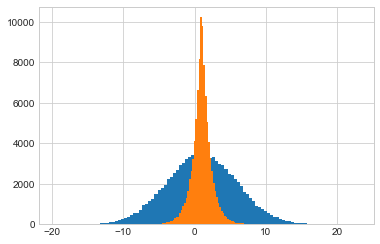

In [30]:
# Comparison of the two distributions
plt.hist([gaussian_mech(1, 1, 1, 1e-5) for _ in range(100000)], bins=100)
plt.hist([laplace_mech(1, 1, 1) for _ in range(100000)], bins=100)

In [28]:
# TEST CASE

results = [gaussian_mech(len(adult[adult['Age'] > 50]), 1, 1.0, 10e-5) for _ in range(100)]
errors = [pct_error(len(adult[adult['Age'] > 50]), r) for r in results]
print('mean error:', np.mean(errors))

assert np.mean(errors) > 0
assert np.mean(errors) < 2

mean error: 0.05624010785361258


## Question 12

How do the Laplace and Gaussian mechanisms compare in terms of relative error on the query "how many individuals are over 50 years old" with $\epsilon = 1$ and $\delta = 10^{-5}$?

In [ ]:
true_answer = len(adult[adult['Age'] > 50])

laplace_answers = [laplace_mech(true_answer, 1, 1) for _ in range(200)]
gaussian_answers = [gaussian_mech(true_answer, 1, 1, 10e-5) for _ in range(200)]

laplace_error = [pct_error(true_answer, a) for a in laplace_answers]
gaussian_error = [pct_error(true_answer, a) for a in gaussian_answers]

_, bins, _ = plt.hist(gaussian_error, bins=20, label='Gaussian')
plt.hist(laplace_error, bins=bins, label='Laplace', alpha=0.5)
plt.legend();

YOUR ANSWER HERE

## Not a Question - Just for reference

[Reference](https://uvm-plaid.github.io/programming-dp/notebooks/ch6.html#the-gaussian-mechanism)

e^epsilon = 2.718281828459045


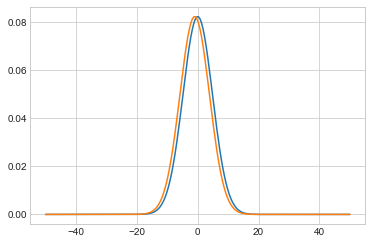

In [31]:
epsilon = 1
sensitivity = 1
delta = 1e-5
sigma_squared = 2 * sensitivity**2 * np.log(1.25 / delta) / (epsilon**2)
sigma = np.sqrt(sigma_squared)

def gauss_pdf(x):
    return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(1/2)*(x/sigma)**2)

xs = np.linspace(-50, 50, 200)
ys1 = [gauss_pdf(x) for x in xs]
ys2 = [gauss_pdf(x+1) for x in xs]

plt.plot(xs,ys1)
plt.plot(xs,ys2)

# ratio < e^epsilon should hold
print('e^epsilon =', np.exp(epsilon))
ratios = [(x, y1 / y2) for x, y1, y2 in zip(xs, ys1, ys2)]
#ratios

e^epsilon = 2.718281828459045


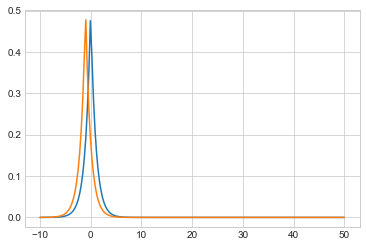

In [37]:
def laplace_pdf(x):
    return (1/2)*epsilon * np.exp(-np.abs(x)*epsilon)
# Although very small, gap gets bigger which means you need a larger epsilon, 
# in fact there is no epsilon value in straight gaussian distr. because there will always be some sort of gap
xs = np.linspace(-10, 50, 200)
ys1 = [laplace_pdf(x) for x in xs]
ys2 = [laplace_pdf(x+1) for x in xs]

plt.plot(xs,ys1)
plt.plot(xs,ys2)

# ratio < e^epsilon should hold
print('e^epsilon =', np.exp(epsilon))
ratios = [(x, y1 / y2) for x, y1, y2 in zip(xs, ys1, ys2)]
#ratios